In [1]:
import pandas as pd
import rdkit
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook
import IPython

In [2]:
zinc_table = pd.read_csv(
    "/gstore/home/tsenga5/discrete_graph_diffusion/data/250k_rndm_zinc_drugs_clean_3.csv",
    sep=",", header=0
)
zinc_table["smiles"] = zinc_table["smiles"].str.strip()
all_smiles = zinc_table["smiles"]

In [3]:
def smiles_to_networkx(smiles_string):
    mol = rdkit.Chem.MolFromSmiles(smiles_string)
    g = nx.Graph()
    for atom in mol.GetAtoms():
        g.add_node(
            atom.GetIdx(),
            atomic_num=atom.GetAtomicNum(),
            is_aromatic=atom.GetIsAromatic(),
            atom_symbol=atom.GetSymbol()
        )
    for bond in mol.GetBonds():
        g.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
            bond_type=bond.GetBondType()
        )
    return g

In [4]:
ATOM_COLORS = {
    "C": "gray",
    "O": "lightcoral",
    "N": "royalblue"
}

def plot_molecule_nx(mol_nx):
    atoms = nx.get_node_attributes(mol_nx, "atom_symbol")
    colors = []
    for node in mol_nx.nodes():
        try:
            colors.append(ATOM_COLORS[mol_nx.nodes[node]["atom_symbol"]])
        except KeyError:
            colors.append("violet")
    nx.draw(
        mol_nx,
        labels=atoms,
        with_labels=True,
        node_color=colors,
        node_size=500
    )
    plt.show()
    
def plot_molecule(mol):
    mc = rdkit.Chem.Mol(mol.ToBinary())
    rdkit.Chem.Kekulize(mc)
    
    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(450, 150)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return IPython.display.SVG(svg.replace("svg:",""))

In [5]:
all_graphs = [
    smiles_to_networkx(s) for s in tqdm.notebook.tqdm(all_smiles)
]

  0%|          | 0/249455 [00:00<?, ?it/s]

In [6]:
all_mols = [
    rdkit.Chem.MolFromSmiles(s) for s in tqdm.notebook.tqdm(all_smiles)
]

  0%|          | 0/249455 [00:00<?, ?it/s]

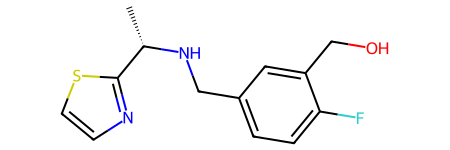

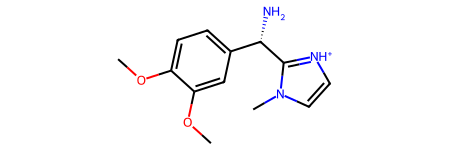

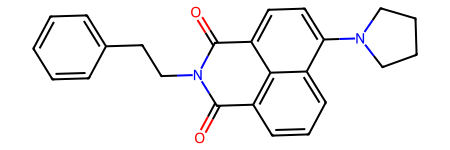

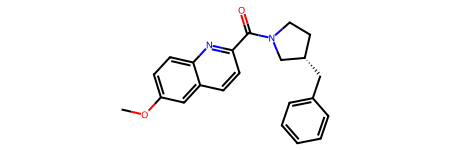

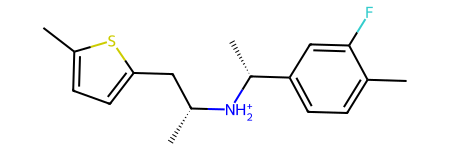

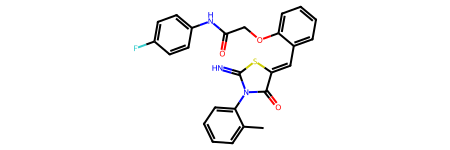

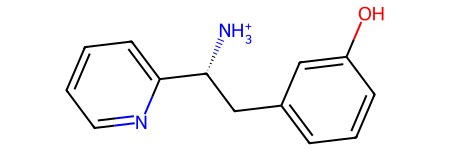

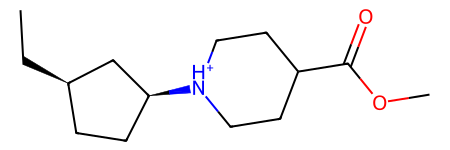

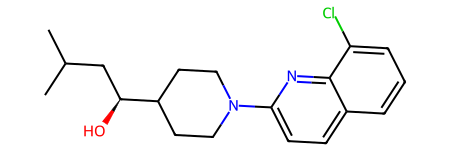

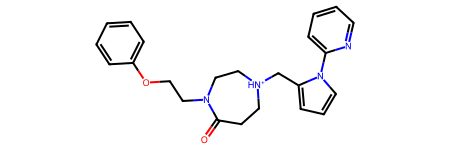

In [7]:
for m in np.random.choice(all_mols, size=10, replace=False):
    IPython.display.display(plot_molecule(m))

### Quantify different attributes

**Aromaticity**

In [8]:
aro = [any(a.GetIsAromatic() for a in m.GetAtoms()) for m in tqdm.notebook.tqdm(all_mols)]

  0%|          | 0/249455 [00:00<?, ?it/s]

In [9]:
np.sum(aro) / len(aro)

0.9333907919263995

**Cyclicity**

In [10]:
cyc_num = np.zeros(len(all_graphs), dtype=int)
bicyc = np.tile(False, len(all_graphs))
for g_i, g in tqdm.notebook.tqdm(enumerate(all_graphs), total=len(all_graphs)):
    cycles = nx.cycle_basis(g)
    cyc_num[g_i] = len(cycles)
    if len(cycles) < 2:
        continue
    cycles = [set(x) for x in cycles]
    for i in range(len(cycles)):
        for j in range(i):
            if cycles[i] & cycles[j]:
                bicyc[g_i] = True

  0%|          | 0/249455 [00:00<?, ?it/s]

In [11]:
np.unique(cyc_num, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 1109, 20544, 83075, 90871, 43435,  9415,   951,    52,     3]))

In [12]:
print(np.sum(bicyc))
print(np.sum(cyc_num[cyc_num >= 2]) - np.sum(bicyc))

86198
579474


**Halogens**

In [13]:
has_halogen = [any(a.GetAtomicNum() in (9, 17, 35, 53) for a in m.GetAtoms()) for m in tqdm.notebook.tqdm(all_mols)]

  0%|          | 0/249455 [00:00<?, ?it/s]

In [14]:
np.sum(has_halogen) / len(has_halogen)

0.35135395161451966

**Macrocyclicity**

In [15]:
has_macrocycle = np.zeros(len(all_mols)).astype(bool)
for i, mol in tqdm.notebook.tqdm(enumerate(all_mols), total=len(all_mols)):
    for ring in mol.GetRingInfo().AtomRings():
        aromatic = all(
            mol.GetAtomWithIdx(atom_ind).GetIsAromatic() for atom_ind in ring
        )
        if not aromatic:
            has_macrocycle[i] = True
            break

  0%|          | 0/249455 [00:00<?, ?it/s]

In [16]:
np.sum(has_macrocycle) / len(has_macrocycle)

0.6488865727285482

**Heteroaromaticity**

In [17]:
heteroaromaticity = np.zeros(len(all_mols))
for i, mol in tqdm.notebook.tqdm(enumerate(all_mols), total=len(all_mols)):
    found_aromatic = False
    found_heteroaromatic = False
    for ring in mol.GetRingInfo().AtomRings():
        aromatic = all(
            mol.GetAtomWithIdx(atom_ind).GetIsAromatic() for atom_ind in ring
        )
        if aromatic:
            heteroaromatic = any(
                mol.GetAtomWithIdx(atom_ind).GetAtomicNum() != 6 for atom_ind in ring
            )
            if heteroaromatic:
                found_heteroaromatic = True
                break
            found_aromatic = True
    if found_heteroaromatic:
        heteroaromaticity[i] = 1
    elif found_aromatic:
        heteroaromaticity[i] = 0
    else:
        heteroaromaticity[i] = -1

  0%|          | 0/249455 [00:00<?, ?it/s]

In [18]:
np.sum(heteroaromaticity != -1)

232839

In [19]:
np.sum(heteroaromaticity == 1) / np.sum(heteroaromaticity != -1)

0.62183740696361